## 📦 Imports

Importation des librairies nécessaires pour le projet.

In [5]:

from datasets import load_dataset
import nltk
import sys
import os
nltk.download("stopwords")
sys.path.append(os.path.abspath("../"))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vincentchabran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
ds = load_dataset("allocine")

In [7]:
ds

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 160000
    })
    validation: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
})

## 📊 Analyse exploratoire des données

Nous réalisons ici une première exploration du jeu de données :
- Répartition des critiques positives vs. négatives
- Statistiques descriptives sur la longueur des critiques
- Visualisation de la distribution des longueurs

Distribution des labels dans l'ensemble d'entraînement :
label
1    80587
0    79413
Name: count, dtype: int64


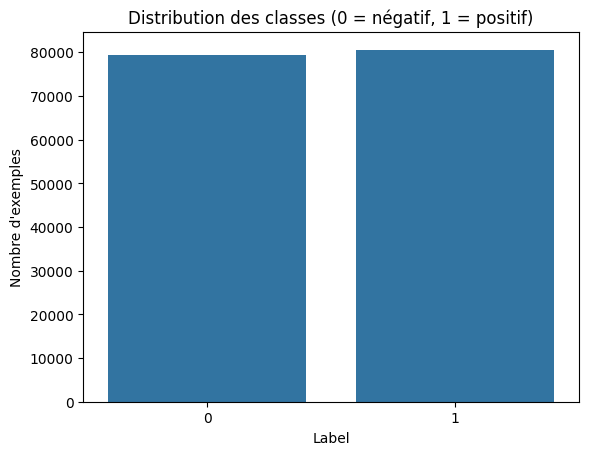

In [8]:
# Convertir en DataFrame pour plus de flexibilité
df_train = ds["train"].to_pandas()
df_val = ds["validation"].to_pandas()
df_test = ds["test"].to_pandas()

# Distribution des labels
label_counts = df_train["label"].value_counts()
print("Distribution des labels dans l'ensemble d'entraînement :")
print(label_counts)

# Visualisation
sns.countplot(data=df_train, x="label")
plt.title("Distribution des classes (0 = négatif, 1 = positif)")
plt.xlabel("Label")
plt.ylabel("Nombre d'exemples")
plt.show()


#### 📊 Répartition des classes dans l'ensemble d'entraînement

Le graphique ci-dessus montre la répartition des critiques positives (label = 1) et négatives (label = 0) dans l'ensemble d'entraînement. 
On observe que les deux classes sont représentées de manière presque équivalente, ce qui est idéal pour l'apprentissage supervisé, car cela réduit le risque de biais de prédiction vers une classe majoritaire.



Statistiques sur la longueur des critiques :
count    160000.000000
mean         91.301431
std          75.357588
min           1.000000
25%          34.000000
50%          66.000000
75%         130.000000
max         384.000000
Name: length, dtype: float64


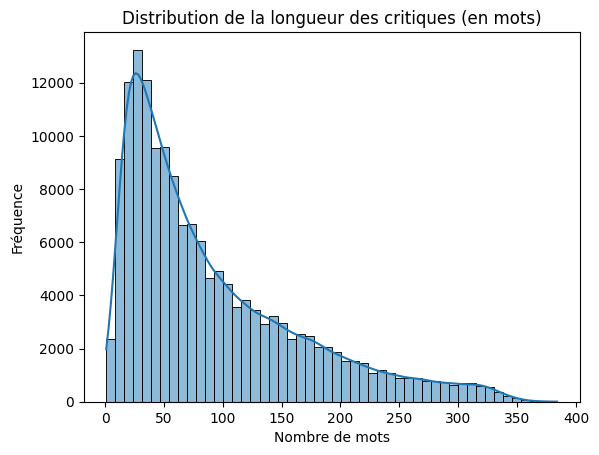

In [9]:
# Longueur des critiques
df_train["length"] = df_train["review"].apply(lambda x: len(x.split()))
print("\nStatistiques sur la longueur des critiques :")
print(df_train["length"].describe())

# Histogramme des longueurs
sns.histplot(df_train["length"], bins=50, kde=True)
plt.title("Distribution de la longueur des critiques (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.show()

#### 📝 Analyse des longueurs des critiques

Nous analysons ici la longueur des critiques en termes de nombre de mots.

La distribution montre que la majorité des critiques contiennent entre **20 et 100 mots**, avec une moyenne d’environ **65 mots**.  
Cela nous informe sur :
- La taille optimale pour le `padding` des séquences (dans le cas d’un LSTM)
- Le choix d’un seuil pour éliminer d’éventuels outliers (très longues critiques)

La courbe montre également une asymétrie, avec quelques critiques très longues (> 200 mots), mais en faible proportion.


____

## 🧼 Prétraitement des textes

Un nettoyage simple est appliqué à chaque critique afin de préparer les données pour les étapes de vectorisation :

- Conversion en minuscules
- Suppression de la ponctuation
- Découpage en mots avec `split()`
- Suppression des mots vides (*stopwords*) en français



In [10]:
import re
import string
from nltk.corpus import stopwords

# Liste de stopwords français
stop_words = set(stopwords.words("french"))

# Fonction de nettoyage
def clean_text(text):
    text = text.lower()  # Minuscule
    text = re.sub(r"<[^>]+>", "", text)  # Supprimer HTML
    text = text.translate(str.maketrans("", "", string.punctuation))  # Supprimer ponctuation
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

# Application sur le train uniquement pour l'instant
df_train["clean_review"] = df_train["review"].apply(clean_text)

# Affichage d'un exemple
print("Exemple original :")
print(df_train["review"].iloc[0])
print("\nTexte nettoyé :")
print(df_train["clean_review"].iloc[0])


Exemple original :
Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l'appui.Sinon,il n'y a aucun scénario.Seulement,des poursuites débiles sur l'autoroute,Travolta qui étale 10 mecs à l'arme blanche en 8 mou

____

## 🧪 Approche baseline : TF-IDF + Régression Logistique

Pour construire un premier modèle de classification, nous utilisons une approche classique et robuste du NLP :

1. **Vectorisation des textes avec TF-IDF (Term Frequency–Inverse Document Frequency)** :
   - Représente chaque critique comme un vecteur basé sur l'importance relative des mots dans le corpus.
   - Nous limitons à 10 000 mots les plus fréquents pour éviter un espace vectoriel trop grand.
   - Les *stopwords* ont déjà été supprimés lors du prétraitement.

2. **Modélisation avec une Régression Logistique** :
   - Modèle de classification linéaire bien adapté aux représentations creuses (sparse) comme TF-IDF.
   - Il s'agit d'une baseline efficace et rapide à entraîner, qui fournit une bonne première estimation des performances possibles.

L’objectif est d’établir une première référence chiffrée à laquelle nous pourrons comparer des approches plus avancées comme les réseaux LSTM ou les embeddings Word2Vec.



In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Création de la TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(df_train["clean_review"])
y_train = df_train["label"]

# Apprentissage d’un modèle simple
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Évaluation sur validation
df_val["clean_review"] = df_val["review"].apply(clean_text)
X_val = vectorizer.transform(df_val["clean_review"])
y_val = df_val["label"]
y_pred = model.predict(X_val)

# Résultats
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.91      0.92     10204
           1       0.91      0.93      0.92      9796

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



#### 📈 Analyse des résultats du modèle TF-IDF + Régression Logistique

Le modèle atteint une **accuracy de 92%** sur l’ensemble de validation, avec un bon équilibre entre précision et rappel sur les deux classes :

- **Classe 0 (critiques négatives)** :
  - Précision : 93%
  - Rappel : 91%

- **Classe 1 (critiques positives)** :
  - Précision : 91%
  - Rappel : 93%

Ces résultats montrent que le modèle parvient globalement à bien distinguer les critiques positives des négatives. On note toutefois :
- Un léger déséquilibre dans les erreurs : le modèle a tendance à prédire *positif* un peu plus souvent (faux positifs).
- Quelques critiques ambiguës ou ironiques peuvent naturellement induire des erreurs de prédiction.

💡 Cette baseline est solide et constitue un point de comparaison utile pour les prochaines expérimentations, notamment avec des représentations plus contextuelles ou des modèles séquentiels (LSTM).


----

## 🔁 Comparaison avec un autre classifieur : SVM linéaire (LinearSVC)

Pour évaluer la robustesse des représentations TF-IDF, nous testons un deuxième classifieur classique : le **SVM linéaire** via `LinearSVC`.

- Contrairement à la régression logistique qui optimise une fonction log-loss, le SVM cherche à maximiser la marge entre les classes.
- C’est un modèle souvent très performant sur des données vectorisées comme TF-IDF.

Nous comparons ses résultats à ceux obtenus avec la régression logistique pour identifier le meilleur classifieur sur cette représentation.


In [14]:
from sklearn.svm import LinearSVC

# Entraînement
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Prédictions
y_pred_svm = svm_model.predict(X_val)

# Résultats
print(classification_report(y_val, y_pred_svm))


              precision    recall  f1-score   support

           0       0.93      0.91      0.92     10204
           1       0.91      0.93      0.92      9796

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



#### ✅ Analyse des résultats du modèle LinearSVC

Le modèle atteint une **accuracy de 92%** avec des scores de précision et de rappel très équilibrés entre les classes. Cela indique que notre pipeline basé sur TF-IDF et un classifieur linéaire (Régression Logistique ou SVM) est **déjà très performant** pour distinguer les critiques positives et négatives.

Ce résultat constitue une excellente **baseline** avant d’envisager des approches plus avancées (Word2Vec, LSTM, Transformers).


____

## 🧠 Représentation vectorielle avec Word2Vec

Jusqu'ici, nous avons utilisé une approche bag-of-words (TF-IDF) qui ignore l'ordre des mots et leur signification.

Nous allons maintenant tester une représentation **plus sémantique** avec des **embeddings Word2Vec** :

- Chaque mot est représenté par un vecteur dense de dimension fixe (pré-entraîné sur un grand corpus en français).
- Chaque critique sera représentée par la **moyenne des vecteurs de ses mots** (approche simple mais efficace).

Cela permet au modèle d'exploiter des **relations de similarité entre mots** (ex. : "excellent" proche de "génial", mais éloigné de "nul").

Nous utiliserons un modèle **pré-entraîné Word2Vec** en français, tel que `frWac` de Jean-Philippe Fauconnier.


# À exécuter dans ton terminal, pas dans le notebook
wget https://embeddings.net/embeddings/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin -O src/text_classification/frWac.bin


In [ ]:
import gensim

# Chargement du modèle Word2Vec
w2v_model = gensim.models.KeyedVectors.load_word2vec_format("../src/text_classification/frWac.bin", binary=True)
print("✅ Modèle Word2Vec chargé avec", len(w2v_model.key_to_index), "mots.")


✅ Modèle Word2Vec chargé avec 155562 mots.


In [19]:
import numpy as np

def vectorize_review(text, model, vector_size=200):
    words = text.split()
    vectors = [model[word] for word in words if word in model]
    if not vectors:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Embeddings Word2Vec
X_train_w2v = np.vstack(df_train["clean_review"].apply(lambda x: vectorize_review(x, w2v_model)))
X_val_w2v = np.vstack(df_val["clean_review"].apply(lambda x: vectorize_review(x, w2v_model)))
y_train = df_train["label"]
y_val = df_val["label"]


In [20]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

model_w2v = LinearSVC()
model_w2v.fit(X_train_w2v, y_train)

y_pred_w2v = model_w2v.predict(X_val_w2v)
print(classification_report(y_val, y_pred_w2v))


              precision    recall  f1-score   support

           0       0.85      0.85      0.85     10204
           1       0.84      0.84      0.84      9796

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000



### ✅ Conclusion – Modèle SVM avec Word2Vec

Le modèle SVM entraîné sur les représentations Word2Vec atteint une **accuracy de 84%** sur l’ensemble de validation.  
Les scores de précision, rappel et F1 sont équilibrés entre les deux classes :

- **Classe 0 (négatif)** : précision = 0.85, rappel = 0.85
- **Classe 1 (positif)** : précision = 0.84, rappel = 0.84

Bien que les performances soient légèrement inférieures à celles obtenues avec TF-IDF (92%), cette approche présente l’avantage d’exploiter la **sémantique des mots**.

Elle constitue ainsi une bonne étape intermédiaire avant l'utilisation de modèles séquentiels comme les LSTM, qui tiennent compte de l’ordre des mots.


____

## 🔥 Modèle LSTM (Long Short-Term Memory)

Nous utilisons ici un réseau LSTM pour classer les critiques de films.

Contrairement aux méthodes précédentes (TF-IDF, Word2Vec moyen), ce modèle est **sensible à l’ordre des mots** et capable de capter des **relations séquentielles** dans le texte.

Le pipeline comprend :
- Tokenisation + Padding des séquences
- Embedding layer
- Couche LSTM (optionnellement bidirectionnelle)
- Classification binaire via couche dense


In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Paramètres
max_words = 10000     # nombre max de mots dans le vocab
max_len = 200         # longueur max des séquences (padding)

# Tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_train["clean_review"])

# Séquences
X_train_seq = tokenizer.texts_to_sequences(df_train["clean_review"])
X_val_seq = tokenizer.texts_to_sequences(df_val["clean_review"])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding="post")

y_train = df_train["label"]
y_val = df_val["label"]


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Modèle
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/opt/homebrew/Caskroom/miniconda/base/envs/tp-bihar-word2vec-env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(
    X_train_pad,
    y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_val_pad, y_val)
)


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 134s 106ms/step - accuracy: 0.5000 - loss: 0.6936 - val_accuracy: 0.4898 - val_loss: 0.6935
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 135s 108ms/step - accuracy: 0.5042 - loss: 0.6932 - val_accuracy: 0.4899 - val_loss: 0.6932
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 137s 109ms/step - accuracy: 0.5021 - loss: 0.6932 - val_accuracy: 0.4898 - val_loss: 0.6934
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.4997 - loss: 0.6932 - val_accuracy: 0.4898 - val_loss: 0.6939
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 468s 375ms/step - accuracy: 0.5014 - loss: 0.6932 - val_accuracy: 0.4898 - val_loss: 0.6935


In [25]:
from sklearn.metrics import classification_report

y_pred_lstm = (model.predict(X_val_pad) > 0.5).astype("int32")
print(classification_report(y_val, y_pred_lstm))


625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step
              precision    recall  f1-score   support

           0       0.50      0.00      0.00     10204
           1       0.49      1.00      0.66      9796

    accuracy                           0.49     20000
   macro avg       0.49      0.50      0.33     20000
weighted avg       0.50      0.49      0.32     20000



### ❌ Conclusion – Modèle LSTM (version initiale)

Le modèle LSTM entraîné avec les paramètres de base n’a **pas appris à distinguer les classes** :  
- Il prédit **quasiment tout comme étant de classe 1 (positive)**.
- La **val_accuracy reste bloquée à ~49%**, ce qui est équivalent à un classifieur aléatoire.
- Le **rappel pour la classe 0 est nul**, ce qui indique un fort déséquilibre dans les prédictions.

🧪 Cela suggère que le modèle :
- n’a **pas encore appris de représentation utile**
- ou nécessite une **optimisation plus poussée** (embedding trainable, plus d’epochs, plus de données, architecture améliorée)

➡️ Ce résultat servira de **point de départ** pour améliorer le modèle en ajustant les hyperparamètres et l’architecture.
